In [1]:
import os
os.chdir('..')
if os.getcwd().split("\\")[-1] == "snu-factcheck-analytics":
    from classes import *
else:
    print('\033[31m\033[43m루트 디렉토리에서 실행해주세요\033[0m')
    print(f'현재 디렉토리는 \033[37m\033[40m{os.getcwd()}\033[0m 입니다.')
    if input("파일이 있는 폴더로 디렉토리를 이동하겠습니까? 'y', 'Y', '' else None : ") in ("y", "Y", ""):
        os.chdir(_dh[0])
    if input("런타임을 재시작하겠습니까? 'y', 'Y', '' else None : ") in ("y", "Y", ""):
        %clear
        %load_ext autoreload
        %autoreload 2

In [2]:
import requests
from bs4 import BeautifulSoup as bs
import yaml
from IPython.display import display
from time import sleep
import re
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from typing import List, Dict, Any, Set, Tuple, Union, Optional


In [4]:
Speaking.scrap_speaking(2,saving_path="data/speakings_with_publisher.yaml")

100%|██████████| 2/2 [00:00<00:00,  4.62it/s]

업데이트된 데이터의 수는 2/2개 입니다.


[<classes.Speaking at 0x1a793f4fc40>, <classes.Speaking at 0x1a794bd68f0>]

In [5]:
speaks_pub = Speaking.scrap_speaking(saving_path="data/speakings_with_publisher.yaml")

 93%|█████████▎| 3739/4000 [16:55<01:10,  3.68it/s]  


3740번째 페이지까지 스크래핑하는데 에러가 연속으로 21번 발생했습니다. 스크래핑을 중단합니다.
업데이트된 데이터의 수는 3334/4000개 입니다.
[Errno 2] No such file or directory: '/data/speakings_with_publisher.yaml'


In [3]:

# 발언을 기준으로 스크래핑한 DB를 팩트체크를 기준으로 변경하는 코드입니다.
fc_dict = {}

for key, value in tqdm(speaks_dict.items()):
    sp_info = value.copy() # 발언의 정보를 복사합니다.
    factchecks = sp_info.pop('factchecks') # 발언의 정보에서 팩트체크를 분리합니다.
    for id, fc in factchecks.items():
        fc_info = fc.copy() # 팩트체크의 정보를 복사합니다.
        fc_info.update(sp_info) # 팩트체크의 정보에 발언의 정보를 추가합니다.
        if id in fc_dict:
            print(id)
        fc_dict[id] = fc_info # 팩트체크의 정보를 딕셔너리에 추가합니다.
print(len(fc_dict))


100%|██████████| 3292/3292 [00:00<00:00, 299177.69it/s]

3549


In [4]:
# 카테고리를 태그화 합니다.
category = set()
for info in speaks_dict.values():
    category|=info['categories']
category_split = set()
for ct in category:
    category_split |= set(ct.split(', '))
print(category_split)

{'사회', 'IT/과학', '19대 대선', '정치인(공직자)과 관련된 사실', '문화', '4.7 재보선', '국회의원 선거', '기타', '4.15 총선', '20대 대통령 선거', '6.13 지방선거', '정치인(공직자)의 발언', '대통령 선거', '국제', '새정부', '코로나 바이러스', '정치', '지방 선거', '경제', '코로나백신'}


In [5]:
for info in fc_dict.values():
    info['categories'] = ", ".join(info['categories'])
    info['splited_cat'] = set(cat for cat in category_split if cat in info['categories'])

In [6]:
fc_df = pd.DataFrame(fc_dict).T
fc_df.head(1)


,content,date,score,time,categories,explain,source,speaker,title,splited_cat
1,검증내용 <앵커>대선 국면에 접어들면서 저희 사실은 코너에선 선거 관련 가짜 뉴스와...,2017.03.29,3,09:51,"정치인(공직자)과 관련된 사실, 정치, 19대 대선, 대통령 선거",현재 지지율 1위 문재인 민주당 경선 후보 아들의 취업특혜 논란과 관련된 가짜 뉴스...,{'[사실은] 문재인 아들 취업 특혜 논란…감사 내용 보니': 'http://new...,문재인,현재 지지율 1위 문재인 민주당 경선 후보 아들과 관련한 취업특혜 논란이 있다.,"{19대 대선, 정치인(공직자)과 관련된 사실, 대통령 선거, 정치}"


In [7]:
display(fc_df.T[12735]["splited_cat"])

{'20대 대통령 선거', '대통령 선거', '사회', '정치', '정치인(공직자)의 발언'}

In [8]:
cat_list = list(category_split)
cat_list.sort()

cat_df = pd.DataFrame([[cat in info["splited_cat"] for cat in cat_list] for id, info in fc_dict.items()], index=fc_df.index, columns=cat_list)
cat_df

,19대 대선,20대 대통령 선거,4.15 총선,4.7 재보선,6.13 지방선거,IT/과학,경제,국제,국회의원 선거,기타,대통령 선거,문화,사회,새정부,정치,정치인(공직자)과 관련된 사실,정치인(공직자)의 발언,지방 선거,코로나 바이러스,코로나백신
1,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True,True,False,False,False,False
26,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True,True,False,False,False,False
27,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True,True,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,True,False,False,False
3,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12735,False,True,False,False,False,False,False,False,False,False,True,False,True,False,True,False,True,False,False,False
12736,False,True,False,False,False,False,False,False,False,False,True,False,True,False,True,False,True,False,False,False
12738,False,True,False,False,False,False,True,False,False,False,True,False,False,False,True,False,True,False,False,False
12732,False,True,False,False,False,False,False,False,False,False,True,False,True,False,True,False,True,False,False,False


In [28]:
cat_score.isna().any().any()

False

In [19]:
cat_score = pd.DataFrame.merge(cat_df, fc_df["score"], left_index=True, right_index=True).fillna(0)
cat_score

,19대 대선,20대 대통령 선거,4.15 총선,4.7 재보선,6.13 지방선거,IT/과학,경제,국제,국회의원 선거,기타,...,문화,사회,새정부,정치,정치인(공직자)과 관련된 사실,정치인(공직자)의 발언,지방 선거,코로나 바이러스,코로나백신,score
1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,True,True,False,False,False,False,3
26,True,False,False,False,False,False,False,False,False,False,...,False,False,False,True,True,False,False,False,False,3
27,True,False,False,False,False,False,False,False,False,False,...,False,False,False,True,True,False,False,False,False,3
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,True,False,False,False,2
3,True,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,True,False,False,False,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12735,False,True,False,False,False,False,False,False,False,False,...,False,True,False,True,False,True,False,False,False,3
12736,False,True,False,False,False,False,False,False,False,False,...,False,True,False,True,False,True,False,False,False,1
12738,False,True,False,False,False,False,True,False,False,False,...,False,False,False,True,False,True,False,False,False,3
12732,False,True,False,False,False,False,False,False,False,False,...,False,True,False,True,False,True,False,False,False,4


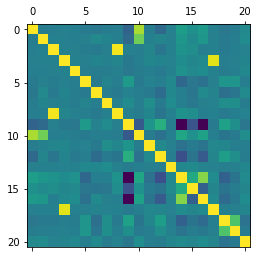

,19대 대선,20대 대통령 선거,4.15 총선,4.7 재보선,6.13 지방선거,IT/과학,경제,국제,국회의원 선거,기타,...,문화,사회,새정부,정치,정치인(공직자)과 관련된 사실,정치인(공직자)의 발언,지방 선거,코로나 바이러스,코로나백신,score
19대 대선,1.000000,-0.040922,-0.030616,-0.017987,-0.028574,-0.061608,-0.078156,-0.049139,-0.030118,-0.229383,...,-0.043695,-0.178147,-0.017987,0.203313,0.099607,0.169288,-0.016708,-0.087885,-0.047341,0.043734
20대 대통령 선거,-0.040922,1.000000,-0.011896,-0.014191,-0.022544,-0.016497,0.043872,0.007773,-0.023762,-0.176773,...,-0.008230,0.016747,-0.014191,0.153892,0.049386,0.150668,-0.013183,-0.054881,-0.029227,0.069881
4.15 총선,-0.030616,-0.011896,1.000000,-0.010617,-0.016867,-0.036366,-0.058455,-0.020112,0.967299,-0.020567,...,0.020334,-0.098670,-0.010617,0.120012,0.084594,-0.025948,-0.009863,-0.051877,-0.027945,-0.004181
4.7 재보선,-0.017987,-0.014191,-0.010617,1.000000,-0.009909,-0.021365,0.008696,-0.009101,0.017177,-0.073276,...,0.023647,0.008137,-0.006238,0.070506,0.022142,0.059902,0.928925,-0.030477,-0.016417,0.012681
6.13 지방선거,-0.028574,-0.022544,-0.016867,-0.009909,1.000000,-0.033940,-0.036168,-0.048416,-0.016592,-0.084294,...,-0.024071,-0.055513,-0.009909,0.112005,0.042835,0.071434,-0.009205,-0.048416,-0.026080,0.039886
IT/과학,-0.061608,-0.016497,-0.036366,-0.021365,-0.033940,1.000000,-0.062422,0.002108,-0.035774,0.162643,...,-0.003574,-0.032495,0.035603,-0.192767,-0.089336,-0.120344,-0.019846,0.135231,0.134505,-0.034797
경제,-0.078156,0.043872,-0.058455,0.008696,-0.036168,-0.062422,1.000000,-0.032215,-0.057326,-0.002535,...,-0.059875,-0.166387,0.036457,-0.027053,-0.093693,0.052080,0.004911,-0.138175,-0.095247,0.059219
국제,-0.049139,0.007773,-0.020112,-0.009101,-0.048416,0.002108,-0.032215,1.000000,-0.018760,0.067409,...,0.089167,-0.057408,0.076404,-0.023620,-0.079547,-0.015379,-0.005319,0.090858,0.092398,-0.045590
국회의원 선거,-0.030118,-0.023762,0.967299,0.017177,-0.016592,-0.035774,-0.057326,-0.018760,1.000000,-0.016080,...,0.021490,-0.100298,-0.010444,0.118058,0.080096,-0.027601,-0.009702,-0.051032,-0.027490,-0.000643
기타,-0.229383,-0.176773,-0.020567,-0.073276,-0.084294,0.162643,-0.002535,0.067409,-0.016080,1.000000,...,0.132941,0.328534,-0.037179,-0.803809,-0.343943,-0.796487,-0.065950,0.229366,0.096166,-0.090163


In [21]:
plt.matshow(cat_score.corr())
plt.show()
cat_score.corr()

In [17]:
groupby_speaker = fc_df.groupby("speaker")

In [138]:
count_index = fc_df.groupby("speaker").count().sort_values("score", ascending=False).index
fc_df[["speaker", "score"]].groupby("speaker").mean().sort_values("score", ascending=False).reindex(count_index).head(20)

,score
speaker,
발언인 없음,2.596026
언론 보도,1.823529
인터넷 루머,1.833333
홍준표,2.081081
문재인,2.522523
온라인 커뮤니티,1.786408
"SNS, 온라인 커뮤니티",1.656863
관련인 없음,2.210526
안철수,2.202703


In [139]:
fc_df.groupby("speaker").count().sort_values("score", ascending=False).head(20)

,content,date,score,time,explain,source,title,categories,splited_cat
speaker,,,,,,,,,
발언인 없음,302,302,302,302,302,302,302,302,302
언론 보도,170,170,170,170,170,170,170,170,170
인터넷 루머,138,138,138,138,138,138,138,138,138
홍준표,111,111,111,111,111,111,111,111,111
문재인,111,111,111,111,111,111,111,111,111
온라인 커뮤니티,103,103,103,103,103,103,103,103,103
"SNS, 온라인 커뮤니티",102,102,102,102,102,102,102,102,102
관련인 없음,95,95,95,95,95,95,95,95,95
안철수,74,74,74,74,74,74,74,74,74


In [18]:
raw_speaker_score = fc_df[["speaker", "score"]].groupby("speaker")
ss_df = raw_speaker_score.count().sort_values("score", ascending=False)
ss_df["mean"] = raw_speaker_score.mean()
ss_df["std"] = raw_speaker_score.std()
ss_df.head(20)

,score,mean,std
speaker,,,
발언인 없음,302,2.596026,1.512644
언론 보도,170,1.823529,1.121880
인터넷 루머,138,1.833333,1.211763
홍준표,111,2.081081,1.258680
문재인,111,2.522523,1.249341
온라인 커뮤니티,103,1.786408,1.209849
"SNS, 온라인 커뮤니티",102,1.656863,1.130102
관련인 없음,95,2.210526,1.577061
안철수,74,2.202703,1.303102


In [161]:
ss_df.to_csv("scrap/speaker_score.csv",encoding="utf-8")

In [19]:
ss_df

,score,mean,std
speaker,,,
발언인 없음,302,2.596026,1.512644
언론 보도,170,1.823529,1.121880
인터넷 루머,138,1.833333,1.211763
홍준표,111,2.081081,1.258680
문재인,111,2.522523,1.249341
...,...,...,...
오션클린업,1,0.000000,NaN
네이버 부동산 커뮤니티,1,2.000000,NaN
오병윤·오현주,1,3.000000,NaN


In [3]:
content_words = pd.concat([pd.read_csv("data/content_word%d.csv"%i) for i in range(3)],axis=1)
content_words.shape

(3549, 29482)